In [1]:
import sys

import polars as pl
import torch


from modeling_module.data_loader.MultiPartDataModule import MultiPartDataModule
from modeling_module.data_loader.MultiPartExoDataModule import MultiPartExoDataModule

'''
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
https://developer.nvidia.com/cuda-12-8-0-download-archive
'''

MAC_DIR = '/Users/igwanhyeong/PycharmProjects/data_research/raw_data/'
WINDOW_DIR = 'C:/Users/USER/PycharmProjects/research/raw_data/'

if sys.platform == 'win32':
    DIR = WINDOW_DIR
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.version.cuda)
    print(torch.__version__)
    print(torch.cuda.get_device_name(0))
    print(torch.__version__)
else:
    DIR = MAC_DIR
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

save_dir = DIR + 'fit/model_validation'


In [3]:
from modeling_module.utils.date_util import DateUtil

ETT1 = (pl.read_csv(DIR + 'csv/ETTm1.csv'))
ETT1_sample = (ETT1
               .select(['date', 'HUFL'])
               .with_columns(pl.lit('A').alias('unique_id'))
               .with_columns(pl.col('date').map_elements(DateUtil.parse_to_yyyymmddhh, return_dtype = pl.Int64).alias('date'))
               )
ETT1_sample

date,HUFL,unique_id
i64,f64,str
2016070100,5.827,"""A"""
2016070100,5.76,"""A"""
2016070100,5.76,"""A"""
2016070100,5.76,"""A"""
2016070101,5.693,"""A"""
…,…,…
2018062618,9.31,"""A"""
2018062619,10.114,"""A"""
2018062619,10.784,"""A"""


In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize = (18, 6))
# plt.plot(ETT1['date'], ETT1['HUFL'])
# plt.xticks(rotation = 90, fontsize = 8)
# plt.title('ETT Dataset - Weekly Mean OT', fontsize = 16)
# plt.xlabel('Year-Week', fontsize = 12)
# plt.ylabel('Mean OT', fontsize = 12)
# plt.grid(True, linestyle = '--', alpha = 0.4)
#
# plt.tight_layout()
# plt.show()

In [4]:
plan_yyyyww = 201801
lookback = 72
horizon = 24

data_module = MultiPartExoDataModule(
    ETT1_sample,
    part_col = 'unique_id',
    date_col = 'date',
    qty_col = 'HUFL',
    lookback = lookback,
    horizon = horizon,
    freq = 'hourly',
    shuffle = False
)

train_loader = data_module.get_train_loader()
val_loader = data_module.get_val_loader()

In [5]:
print("len(train_dataset) =", len(data_module.train_dataset))
print("len(val_dataset)   =", len(data_module.val_dataset))

train_loader = data_module.get_train_loader()
val_loader   = data_module.get_val_loader()

print("len(train_loader) =", len(train_loader))
print("len(val_loader)   =", len(val_loader))


len(train_dataset) = 55668
len(val_dataset)   = 13917
len(train_loader) = 1739
len(val_loader)   = 435


In [7]:
from modeling_module.training.model_trainers.total_train import run_total_train_monthly, run_total_train_weekly, \
    run_total_train_hourly

model_dict = run_total_train_hourly(
    train_loader,
    val_loader,
    lookback = lookback,
    horizon = horizon,
    save_dir = save_dir
)

PatchMixer Base (Hourly)
[EXO-setup] inferred E=4, model.exo_dim=4, has_head=True

[train_patchmixer] ===== Stage 1/2 =====
  - spike: OFF
  - epochs: 20 | lr=0.0001 | horizon_decay=False
[train_patchmixer] Effective TrainingConfig:
{
  "device": "cpu",
  "lookback": 72,
  "horizon": 24,
  "epochs": 20,
  "lr": 0.0001,
  "weight_decay": 0.001,
  "t_max": 40,
  "patience": 100,
  "max_grad_norm": 30.0,
  "amp_device": "cuda",
  "loss_mode": "point",
  "point_loss": "huber",
  "huber_delta": 0.8,
  "q_star": 0.5,
  "use_cost_q_star": false,
  "Cu": 1.0,
  "Co": 1.0,
  "quantiles": [
    0.1,
    0.5,
    0.9
  ],
  "use_intermittent": true,
  "alpha_zero": 3.0,
  "alpha_pos": 1.0,
  "gamma_run": 0.3,
  "cap": null,
  "use_horizon_decay": false,
  "tau_h": 0.85,
  "val_use_weights": false,
  "spike_loss": {
    "enabled": false,
    "strategy": "mix",
    "huber_delta": 0.6,
    "asym_up_weight": 1.0,
    "asym_down_weight": 8.0,
    "mad_k": 1.5,
    "w_spike": 32.0,
    "w_norm": 1.0,
 

KeyboardInterrupt: 

In [ ]:
from modeling_module.utils.checkpoint import load_model_dict
# Load
from modeling_module.models.model_builder import (
    build_patch_mixer_quantile,
    build_patchTST_base, build_patchTST_quantile, build_patch_mixer_base, build_titan_base, build_titan_lmm,
    build_titan_seq2seq,
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

builders = {
    # f"weekly_PatchMixerBase_L{lookback}_H{horizon}": build_patch_mixer_base,
    # f"weekly_PatchMixerQuantile_L{lookback}_H{horizon}": build_patch_mixer_quantile,
    f"weekly_TitanBase_L{lookback}_H{horizon}": build_titan_base,
    f"weekly_TitanLMM_L{lookback}_H{horizon}": build_titan_lmm,
    f"weekly_TitanSeq2Seq_L{lookback}_H{horizon}": build_titan_seq2seq,
    # f"weekly_PatchTSTBase_L{lookback}_H{horizon}": build_patchTST_base,
    # f"weekly_PatchTSTQuantile_L{lookback}_H{horizon}": build_patchTST_quantile,
}
loaded = load_model_dict(save_dir, builders, device = device)

In [ ]:
%load_ext autoreload
%autoreload 2

import importlib, modeling_module.utils.plot_utils as pu
import modeling_module.training.forecaster as fo
importlib.reload(pu)
importlib.reload(fo)

def my_exo_cb(start_idx: int, Hm: int, device="cuda" if torch.cuda.is_available() else "cpu"):
    # exo_dim = 2 (sin, cos)
    return fo.make_calendar_exo(start_idx, Hm, period=54, device=device)

pu.plot_27w(
    models=loaded,           # {"PatchMixer": pm_model, "Titan": ti_model, ...}
    loader=val_loader,       # (xb, yb[, part_ids])
    device="cuda" if torch.cuda.is_available() else "cpu",
    mode="val",              # ← 검증 모드
    max_plots=1,
    out_dir=None,
    show=True,
    future_exo_cb=my_exo_cb
)

MAE (test horizon=12): 1.5154


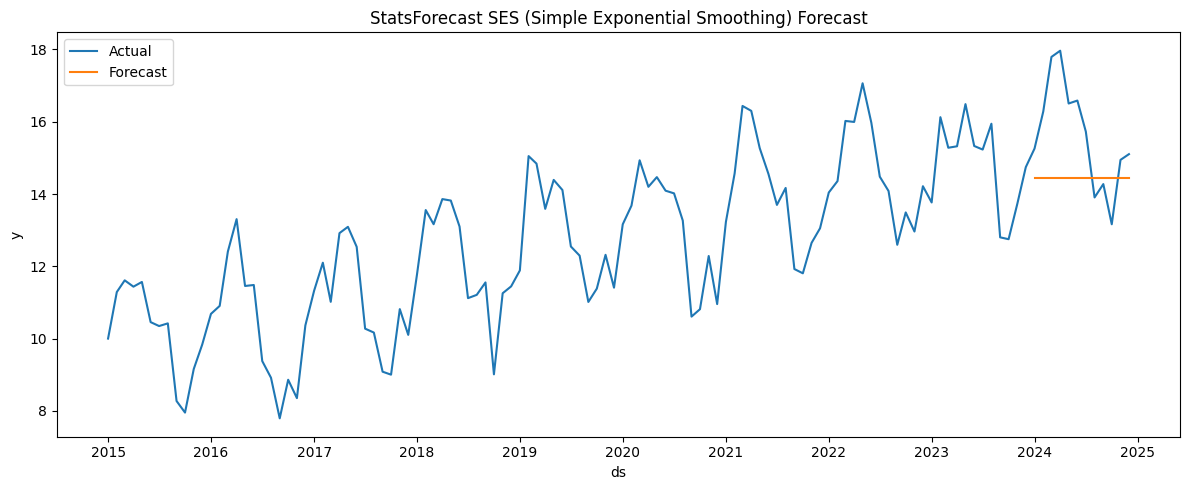

In [8]:
"""
Nixtla StatsForecast SES(Simple Exponential Smoothing) 샘플 코드

- 단일 시계열 예측 (월/주/일 등 어떤 주기든 가능)
- `unique_id`, `ds`, `y` 컬럼 포맷 사용(StatsForecast 표준)
- Train/Test 분리 및 간단한 평가(MAE)
- 예측 결과 시각화

참고:
- SES는 level(수준)만 추정하는 가장 기본적인 지수평활법.
- trend/seasonality를 명시적으로 모델링하지 않으므로, 강한 계절성/추세가 있으면 성능이 제한될 수 있음.
"""

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import SimpleExponentialSmoothing


def make_sample_data(
    n: int = 120,
    freq: str = "MS",          # "D", "W", "MS"(월초), "M"(월말) 등
    start: str = "2015-01-01",
    seed: int = 7,
) -> pd.DataFrame:
    """샘플 시계열 데이터 생성 (trend + seasonality + noise)."""
    rng = np.random.default_rng(seed)
    ds = pd.date_range(start=start, periods=n, freq=freq)

    t = np.arange(n)
    trend = 0.05 * t
    season = 2.0 * np.sin(2 * np.pi * t / 12)  # 월 기준 12계절(예시)
    noise = rng.normal(0, 0.8, size=n)

    y = 10 + trend + season + noise

    df = pd.DataFrame({
        "unique_id": "series_1",
        "ds": ds,
        "y": y,
    })
    return df


def train_test_split(
    df: pd.DataFrame,
    test_size: int = 12,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """마지막 test_size 포인트를 테스트로 분리."""
    df = df.sort_values(["unique_id", "ds"]).reset_index(drop=True)
    train = df.iloc[:-test_size].copy()
    test = df.iloc[-test_size:].copy()
    return train, test


def fit_and_forecast(
    train_df: pd.DataFrame,
    h: int,
    n_jobs: int = 1,
) -> pd.DataFrame:
    """
    SES 학습 후 h-step 예측.
    반환: [unique_id, ds, SimpleExponentialSmoothing] 형태의 예측 DataFrame

    - SimpleExponentialSmoothing은 season_length 파라미터가 없습니다(계절성 미모델링).
    """
    model = SimpleExponentialSmoothing(alpha = 0.1)

    sf = StatsForecast(
        models=[model],
        freq=pd.infer_freq(train_df["ds"]) or "MS",
        n_jobs=n_jobs,
    )

    fcst = sf.forecast(df=train_df, h=h)
    return fcst


def evaluate_mae(
    test_df: pd.DataFrame,
    fcst_df: pd.DataFrame,
    pred_col: str = "SimpleExponentialSmoothing",
) -> float:
    """테스트 구간에 대한 MAE 계산."""
    merged = test_df.merge(fcst_df, on=["unique_id", "ds"], how="inner")
    mae = float(np.mean(np.abs(merged["y"] - merged[pred_col])))
    return mae


def plot_forecast(
    df_all: pd.DataFrame,
    fcst_df: pd.DataFrame,
    pred_col: str = "SimpleExponentialSmoothing",
    title: str = "StatsForecast SES (Simple Exponential Smoothing) Forecast",
) -> None:
    """실제값 + 예측값 라인 플롯."""
    df_all = df_all.sort_values("ds")
    fcst_df = fcst_df.sort_values("ds")

    plt.figure(figsize=(12, 5))
    plt.plot(df_all["ds"], df_all["y"], label="Actual")
    plt.plot(fcst_df["ds"], fcst_df[pred_col], label="Forecast")
    plt.title(title)
    plt.xlabel("ds")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.show()


def main():
    # 1) 데이터 생성
    df = make_sample_data(n=120, freq="MS", start="2015-01-01")

    # 2) Train/Test 분리
    train_df, test_df = train_test_split(df, test_size=12)

    # 3) 학습/예측
    h = len(test_df)
    fcst_df = fit_and_forecast(
        train_df=train_df,
        h=h,
        n_jobs=1,
    )

    # 4) 평가(옵션)
    mae = evaluate_mae(test_df=test_df, fcst_df=fcst_df, pred_col="SES")
    print(f"MAE (test horizon={h}): {mae:.4f}")

    # 5) 시각화
    plot_forecast(df_all=df, fcst_df=fcst_df, pred_col="SES")


if __name__ == "__main__":
    main()


MAE (test horizon=12): 1.3572


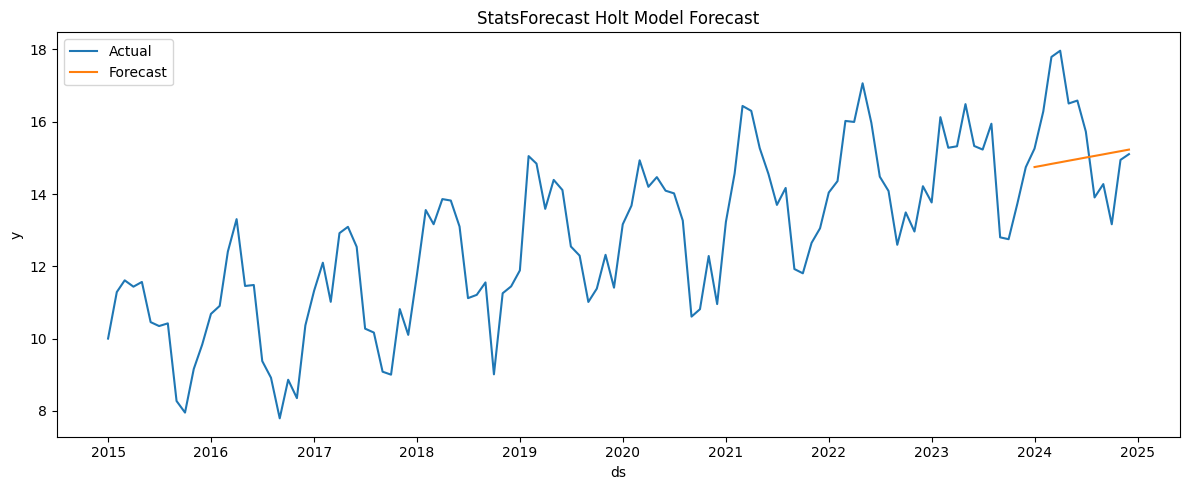

In [15]:
"""
Nixtla StatsForecast Holt(=Holt's Linear Trend) 모델 샘플 코드

- 단일 시계열 예측 (월/주/일 등 어떤 주기든 가능)
- `unique_id`, `ds`, `y` 컬럼 포맷 사용(StatsForecast 표준)
- Train/Test 분리 및 간단한 평가(MAE)
- 예측 결과 시각화

참고:
- Holt는 (level + trend)를 지수평활로 추정하는 모델.
- 계절성(seasonality)은 포함하지 않습니다. (계절성까지 필요하면 HoltWinters 계열 사용)
"""

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import Holt


def make_sample_data(
    n: int = 120,
    freq: str = "MS",          # "D", "W", "MS"(월초), "M"(월말) 등
    start: str = "2015-01-01",
    seed: int = 7,
) -> pd.DataFrame:
    """샘플 시계열 데이터 생성 (trend + seasonality + noise)."""
    rng = np.random.default_rng(seed)
    ds = pd.date_range(start=start, periods=n, freq=freq)

    t = np.arange(n)
    trend = 0.05 * t
    season = 2.0 * np.sin(2 * np.pi * t / 12)  # 월 기준 12계절(예시)
    noise = rng.normal(0, 0.8, size=n)

    y = 10 + trend + season + noise

    df = pd.DataFrame({
        "unique_id": "series_1",
        "ds": ds,
        "y": y,
    })
    return df


def train_test_split(
    df: pd.DataFrame,
    test_size: int = 12,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """마지막 test_size 포인트를 테스트로 분리."""
    df = df.sort_values(["unique_id", "ds"]).reset_index(drop=True)
    train = df.iloc[:-test_size].copy()
    test = df.iloc[-test_size:].copy()
    return train, test


def fit_and_forecast(
    train_df: pd.DataFrame,
    h: int,
    *,
    n_jobs: int = 1,
    # Holt 옵션 예시 (필요 시 조정)
    # damped_trend: trend를 감쇠(damping)할지 여부 (장기 예측에서 과도한 추세 발산 완화)
) -> pd.DataFrame:
    """
    Holt 학습 후 h-step 예측.
    반환: [unique_id, ds, Holt] 형태의 예측 DataFrame

    주의:
    - StatsForecast Holt는 계절성 파라미터가 없음(계절성 미모델링).
    """
    model = Holt(
        season_length = 12,
        alias = 'Holt'
    )

    sf = StatsForecast(
        models=[model],
        freq=pd.infer_freq(train_df["ds"]) or "MS",
        n_jobs=n_jobs,
    )

    fcst = sf.forecast(df=train_df, h=h)
    return fcst


def evaluate_mae(
    test_df: pd.DataFrame,
    fcst_df: pd.DataFrame,
    pred_col: str = "Holt",
) -> float:
    """테스트 구간에 대한 MAE 계산."""
    merged = test_df.merge(fcst_df, on=["unique_id", "ds"], how="inner")
    mae = float(np.mean(np.abs(merged["y"] - merged[pred_col])))
    return mae


def plot_forecast(
    df_all: pd.DataFrame,
    fcst_df: pd.DataFrame,
    pred_col: str = "Holt",
    title: str = "StatsForecast Holt Model Forecast",
) -> None:
    """실제값 + 예측값 라인 플롯."""
    df_all = df_all.sort_values("ds")
    fcst_df = fcst_df.sort_values("ds")

    plt.figure(figsize=(12, 5))
    plt.plot(df_all["ds"], df_all["y"], label="Actual")
    plt.plot(fcst_df["ds"], fcst_df[pred_col], label="Forecast")
    plt.title(title)
    plt.xlabel("ds")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.show()


def main():
    # 1) 데이터 생성
    df = make_sample_data(n=120, freq="MS", start="2015-01-01")

    # 2) Train/Test 분리
    train_df, test_df = train_test_split(df, test_size=12)

    # 3) 학습/예측
    h = len(test_df)
    fcst_df = fit_and_forecast(
        train_df=train_df,
        h=h,
        n_jobs=1,
    )

    # 4) 평가(옵션)
    mae = evaluate_mae(test_df=test_df, fcst_df=fcst_df, pred_col="Holt")
    print(f"MAE (test horizon={h}): {mae:.4f}")

    # 5) 시각화
    plot_forecast(df_all=df, fcst_df=fcst_df, pred_col="Holt")


if __name__ == "__main__":
    main()


MAE (test horizon=12): 0.5032


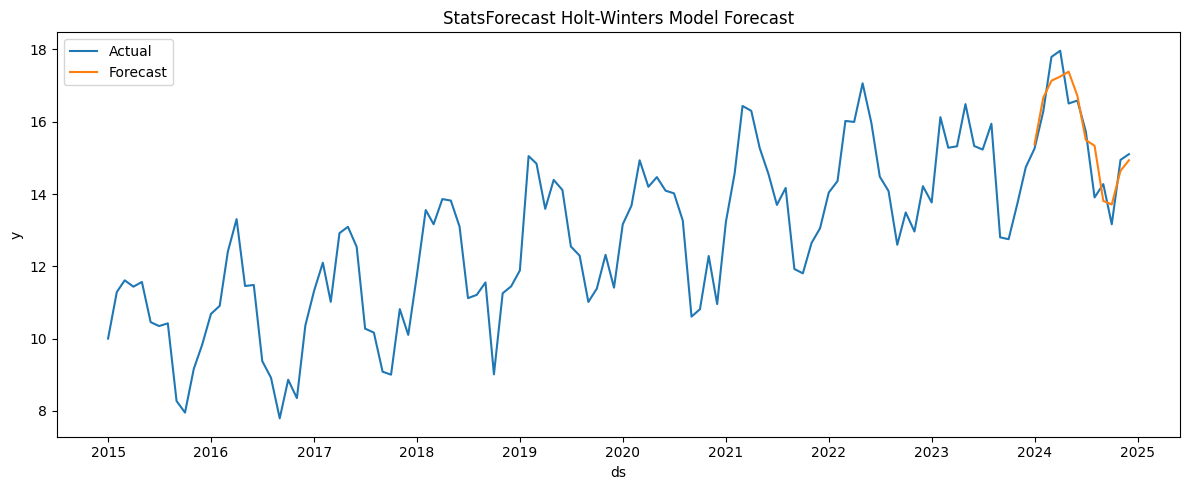

In [17]:
"""
Nixtla StatsForecast Holt-Winters(=Triple Exponential Smoothing) 모델 샘플 코드

- 단일 시계열 예측 (월/주/일 등 어떤 주기든 가능)
- `unique_id`, `ds`, `y` 컬럼 포맷 사용(StatsForecast 표준)
- Train/Test 분리 및 간단한 평가(MAE)
- 예측 결과 시각화

핵심 파라미터:
- season_length: 계절 주기 (월=12, 주=52, 일=7 등)
- seasonality: "additive" 또는 "multiplicative"
- trend: "additive" 또는 None
- damped_trend: 추세 감쇠 여부 (장기 예측에서 과도한 추세 발산 완화)

참고:
- Holt-Winters는 (level + trend + seasonality)를 모두 모델링합니다.
- 데이터가 0 또는 음수가 있으면 multiplicative seasonality/trend에서 문제가 될 수 있음.
"""

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import HoltWinters


def make_sample_data(
    n: int = 120,
    freq: str = "MS",          # "D", "W", "MS"(월초), "M"(월말) 등
    start: str = "2015-01-01",
    seed: int = 7,
) -> pd.DataFrame:
    """샘플 시계열 데이터 생성 (trend + seasonality + noise)."""
    rng = np.random.default_rng(seed)
    ds = pd.date_range(start=start, periods=n, freq=freq)

    t = np.arange(n)
    trend = 0.05 * t
    season = 2.0 * np.sin(2 * np.pi * t / 12)  # 월 기준 12계절(예시)
    noise = rng.normal(0, 0.8, size=n)

    y = 10 + trend + season + noise

    df = pd.DataFrame({
        "unique_id": "series_1",
        "ds": ds,
        "y": y,
    })
    return df


def train_test_split(
    df: pd.DataFrame,
    test_size: int = 12,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """마지막 test_size 포인트를 테스트로 분리."""
    df = df.sort_values(["unique_id", "ds"]).reset_index(drop=True)
    train = df.iloc[:-test_size].copy()
    test = df.iloc[-test_size:].copy()
    return train, test


def fit_and_forecast(
    train_df: pd.DataFrame,
    h: int,
    *,
    season_length: int = 12,          # 월별이면 12, 주별이면 52, 일별이면 7
    n_jobs: int = 1,
) -> pd.DataFrame:
    """
    Holt-Winters 학습 후 h-step 예측.
    반환: [unique_id, ds, HoltWinters] 형태의 예측 DataFrame
    """
    model = HoltWinters(
        season_length=season_length,
    )

    sf = StatsForecast(
        models=[model],
        freq=pd.infer_freq(train_df["ds"]) or "MS",
        n_jobs=n_jobs,
    )

    fcst = sf.forecast(df=train_df, h=h)
    return fcst


def evaluate_mae(
    test_df: pd.DataFrame,
    fcst_df: pd.DataFrame,
    pred_col: str = "HoltWinters",
) -> float:
    """테스트 구간에 대한 MAE 계산."""
    merged = test_df.merge(fcst_df, on=["unique_id", "ds"], how="inner")
    mae = float(np.mean(np.abs(merged["y"] - merged[pred_col])))
    return mae


def plot_forecast(
    df_all: pd.DataFrame,
    fcst_df: pd.DataFrame,
    pred_col: str = "HoltWinters",
    title: str = "StatsForecast Holt-Winters Model Forecast",
) -> None:
    """실제값 + 예측값 라인 플롯."""
    df_all = df_all.sort_values("ds")
    fcst_df = fcst_df.sort_values("ds")

    plt.figure(figsize=(12, 5))
    plt.plot(df_all["ds"], df_all["y"], label="Actual")
    plt.plot(fcst_df["ds"], fcst_df[pred_col], label="Forecast")
    plt.title(title)
    plt.xlabel("ds")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.show()


def main():
    # 1) 데이터 생성
    df = make_sample_data(n=120, freq="MS", start="2015-01-01")

    # 2) Train/Test 분리
    train_df, test_df = train_test_split(df, test_size=12)

    # 3) 학습/예측
    h = len(test_df)
    fcst_df = fit_and_forecast(
        train_df=train_df,
        h=h,
        season_length=12,
        n_jobs=1,
    )

    # 4) 평가(옵션)
    mae = evaluate_mae(test_df=test_df, fcst_df=fcst_df, pred_col="HoltWinters")
    print(f"MAE (test horizon={h}): {mae:.4f}")

    # 5) 시각화
    plot_forecast(df_all=df, fcst_df=fcst_df, pred_col="HoltWinters")


if __name__ == "__main__":
    main()


MAE (test horizon=24): 1.2057


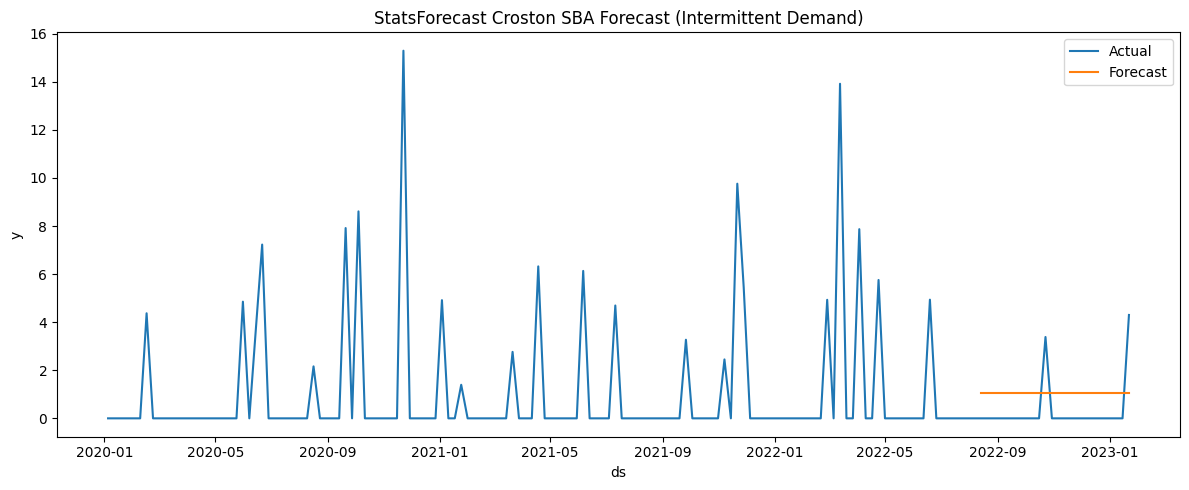

In [18]:
"""
Nixtla StatsForecast Croston SBA (Syntetos–Boylan Approximation) 샘플 코드

- 간헐 수요(Intermittent demand) 예측에 주로 사용
- `unique_id`, `ds`, `y` 컬럼 포맷 사용(StatsForecast 표준)
- Train/Test 분리 및 간단한 평가(MAE)
- 예측 결과 시각화

핵심 개념:
- Croston 계열은 "수요 발생 크기"와 "발생 간격"을 분리해 지수평활로 추정.
- SBA는 Croston의 편향(bias)을 보정한 변형(일반적으로 과대추정 완화).

주의:
- 데이터 주기는 월/주/일 등 무엇이든 가능하나, 간헐 수요는 보통 주/월에서 많이 사용.
- y는 0이 많이 포함된 non-negative 수요량을 가정.
"""

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import CrostonSBA


def make_intermittent_sample_data(
    n: int = 160,
    freq: str = "W",            # 간헐수요는 보통 주/월 추천: "W", "MS"
    start: str = "2020-01-05",
    seed: int = 7,
    p_nonzero: float = 0.18,    # 0이 아닌 수요 발생 확률
) -> pd.DataFrame:
    """
    간헐 수요 샘플 데이터 생성:
    - 대부분 0, 가끔 양수 수요 발생
    """
    rng = np.random.default_rng(seed)
    ds = pd.date_range(start=start, periods=n, freq=freq)

    # 발생 여부(베르누이)
    occur = rng.uniform(size=n) < p_nonzero

    # 발생 시 수요 크기(예: 로그정규/감마/포아송 등 선택 가능)
    size = rng.lognormal(mean=1.6, sigma=0.6, size=n)

    y = np.where(occur, size, 0.0)

    df = pd.DataFrame({
        "unique_id": "part_1",
        "ds": ds,
        "y": y,
    })
    return df


def train_test_split(
    df: pd.DataFrame,
    test_size: int = 24,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """마지막 test_size 포인트를 테스트로 분리."""
    df = df.sort_values(["unique_id", "ds"]).reset_index(drop=True)
    train = df.iloc[:-test_size].copy()
    test = df.iloc[-test_size:].copy()
    return train, test


def fit_and_forecast(
    train_df: pd.DataFrame,
    h: int,
    *,
    n_jobs: int = 1,
) -> pd.DataFrame:
    """
    Croston SBA 학습 후 h-step 예측.
    반환: [unique_id, ds, CrostonSBA] 형태의 예측 DataFrame
    """
    model = CrostonSBA()

    sf = StatsForecast(
        models=[model],
        freq=pd.infer_freq(train_df["ds"]) or "W",
        n_jobs=n_jobs,
    )

    fcst = sf.forecast(df=train_df, h=h)
    return fcst


def evaluate_mae(
    test_df: pd.DataFrame,
    fcst_df: pd.DataFrame,
    pred_col: str = "CrostonSBA",
) -> float:
    """테스트 구간에 대한 MAE 계산."""
    merged = test_df.merge(fcst_df, on=["unique_id", "ds"], how="inner")
    mae = float(np.mean(np.abs(merged["y"] - merged[pred_col])))
    return mae


def plot_forecast(
    df_all: pd.DataFrame,
    fcst_df: pd.DataFrame,
    pred_col: str = "CrostonSBA",
    title: str = "StatsForecast Croston SBA Forecast (Intermittent Demand)",
) -> None:
    """실제값(스파이크/제로) + 예측값 플롯."""
    df_all = df_all.sort_values("ds")
    fcst_df = fcst_df.sort_values("ds")

    plt.figure(figsize=(12, 5))
    plt.plot(df_all["ds"], df_all["y"], label="Actual")
    plt.plot(fcst_df["ds"], fcst_df[pred_col], label="Forecast")
    plt.title(title)
    plt.xlabel("ds")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.show()


def main():
    # 1) 간헐 수요 데이터 생성
    df = make_intermittent_sample_data(
        n=160,
        freq="W",
        start="2020-01-05",
        p_nonzero=0.18,
    )

    # 2) Train/Test 분리
    train_df, test_df = train_test_split(df, test_size=24)

    # 3) 학습/예측
    h = len(test_df)
    fcst_df = fit_and_forecast(
        train_df=train_df,
        h=h,
        n_jobs=1,
    )

    # 4) 평가(옵션)
    mae = evaluate_mae(test_df=test_df, fcst_df=fcst_df, pred_col="CrostonSBA")
    print(f"MAE (test horizon={h}): {mae:.4f}")

    # 5) 시각화
    plot_forecast(df_all=df, fcst_df=fcst_df, pred_col="CrostonSBA")


if __name__ == "__main__":
    main()


Seed set to 1
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type              | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss         | DistributionLoss  | 5      | train | 0    
1 | padder_train | ConstantPad1d     | 0      | train | 0    
2 | scaler       | TemporalNorm      | 0      | train | 0    
3 | model        | PatchTST_backbone | 32.2 K | train | 0    
-------------------------------------------------------------------
32.2 K    Trainable params
8         Non-trainable params
32.3 K    Total params
0.129     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 21.42it/s, v_num=3, train_loss_step=4.850, train_loss_epoch=4.890]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.45it/s, v_num=3, train_loss_step=4.350, train_loss_epoch=4.350, valid_loss=5.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 22.00it/s, v_num=3, train_loss_step=4.130, train_loss_epoch=4.140, valid_loss=5.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s, v_num=3, train_loss_step=4.130, train_loss_epoch=4.130, valid_loss=6.210]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.00it/s]
MAE (h=12): 19.1370


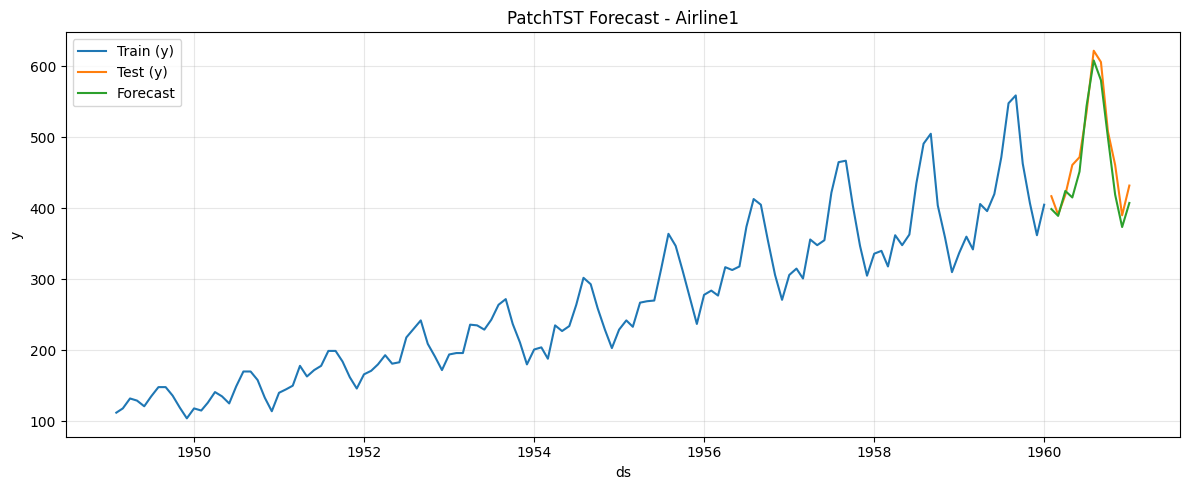

In [23]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic, augment_calendar_df


def train_test_split_last_horizon(df: pd.DataFrame, h: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    df = df.sort_values(["unique_id", "ds"]).reset_index(drop=True)
    test_mask = df.groupby("unique_id").cumcount(ascending=False) < h
    return df[~test_mask].copy(), df[test_mask].copy()


def main():
    # 1) 데이터 + 캘린더 exog
    y_df, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq="M")

    # 2) split
    h = 12
    y_train_df, y_test_df = train_test_split_last_horizon(y_df, h=h)

    # 3) 모델 (핵심: scaler_type을 robust -> standard/identity로 변경)
    model = PatchTST(
        h=h,
        input_size=104,
        patch_len=24,
        stride=24,

        # 선택 1) MPS 호환: standard
        scaler_type="standard",

        # 선택 2) 스케일링 없이 RevIN으로만 처리하고 싶으면:
        # scaler_type="identity",
        # revin=True,

        hidden_size=16,
        n_heads=4,
        loss=DistributionLoss(distribution="StudentT", level=[80, 90]),

        learning_rate=1e-3,
        max_steps=500,
        val_check_steps=50,
        early_stop_patience_steps=2,
        accelerator='cpu'
    )

    nf = NeuralForecast(models=[model], freq="ME")

    # 4) fit
    nf.fit(df=y_train_df, static_df=AirPassengersStatic, val_size=h)

    # 5) predict
    fcst = nf.predict(futr_df=y_test_df).reset_index(drop=False)

    # 6) MAE (median 우선)
    merged = y_test_df.merge(fcst, on=["unique_id", "ds"], how="inner")
    pred_col = "PatchTST-median" if "PatchTST-median" in merged.columns else "PatchTST"
    mae = float(np.mean(np.abs(merged["y"].to_numpy() - merged[pred_col].to_numpy())))
    print(f"MAE (h={h}): {mae:.4f}")

    # 7) plot (첫 uid만)
    uid = merged["unique_id"].iloc[0]
    tr = y_train_df[y_train_df["unique_id"] == uid].copy()
    te = merged[merged["unique_id"] == uid].copy()

    plt.figure(figsize=(12, 5))
    plt.plot(tr["ds"], tr["y"], label="Train (y)")
    plt.plot(te["ds"], te["y"], label="Test (y)")
    plt.plot(te["ds"], te[pred_col], label="Forecast")
    plt.title(f"PatchTST Forecast - {uid}")
    plt.xlabel("ds")
    plt.ylabel("y")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
